In [1]:
!pip install bayesian-optimization
!pip install pyproj

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from pyproj import Proj,transform
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.metrics import accuracy_score,log_loss,f1_score
from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV    
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings       
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math

from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Colab 한글 적용

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


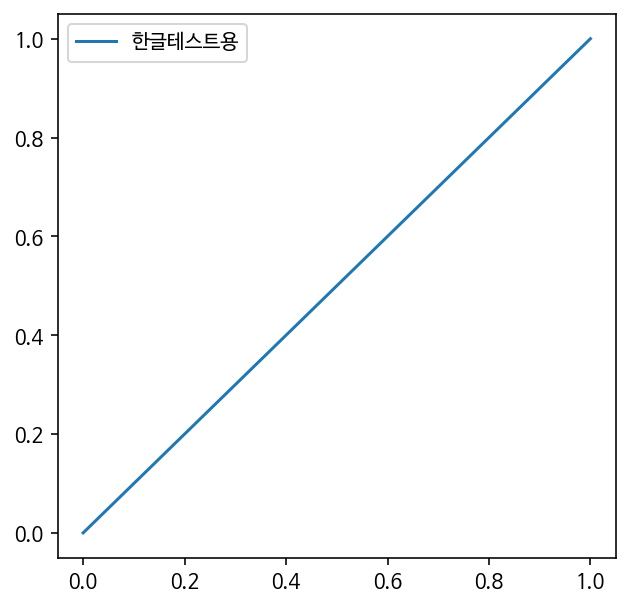

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# Load Data
- 직사각형 100만, Euclid: 150


In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_십만_150.csv',encoding='cp949')
data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']

In [6]:
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building
0,195600.888993,545928.299315,6,0,0,1,0,0,0,0,0.0,1.0,5.0,93.0,45.0,0.0,0.0,0.0,0.000000,0.010753
1,194062.308207,544725.091085,19,0,0,1,0,0,0,0,1.0,3.0,4.0,219.0,2.0,0.0,2.0,1.0,0.004566,0.013699
2,197377.867009,543986.683138,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,193058.182323,543489.087262,0,0,0,0,0,0,0,0,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.000000,0.071429
4,197347.383013,542701.828076,23,0,0,3,0,0,0,0,4.0,2.0,3.0,258.0,4.0,0.0,1.0,1.0,0.015504,0.007752


In [0]:
# 이진분류
data.loc[data['old_acc']==0,'binary_accident']=0
data.loc[data['old_acc']!=0,'binary_accident']=1

# K-Distance 구하기
- 소로, old/building, crosswork, bus
- DBSCAN의 최적의 eps를 구하기 위해서는 Knn의 Distance를 구해야한다.

즉, KnnClassification 분류모델을 활용하여 최적의 NearestNeighbors의 하이퍼 파라미터들(n_neighbors,leaf_size,p 등)을 찾음. 그 후, NearestNeighbors 모델을 활용해 Distance의 분포를 확인 한 뒤, DBSCAN의 적정 eps를 찾으면 끝

베이지안 최적화 방법을 통해 최적의 n_neighbors를 구한다.

In [0]:
robust_scaler = RobustScaler()

x=data[['old/building','bus','소로','crosswork']]
x.replace([np.inf, -np.inf], 0, inplace=True)
x.fillna(0,inplace=True)
scaled_X=robust_scaler.fit_transform(x)

In [0]:
X_train = pd.DataFrame(scaled_X,columns=x.columns)
y_train = data['binary_accident']

In [0]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cv(n_neighbors,leaf_size,p, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    #kf = KFold(n_splits=n_splits)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
        #print(train_index)
        x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
        #Smote
        sm = SMOTE(ratio='auto', kind='regular')
        # train데이터를 넣어 복제함
        X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
        x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]

        model = KNeighborsClassifier(
            n_neighbors = int(n_neighbors),
            leaf_size = int(leaf_size),
            p = int(p),
            n_jobs=-1,
            metric= 'euclidean',
            #'mahalanobis',#'seuclidean',#'chebyshev',#'manhattan',#'euclidean', #'minkowski', 

        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [11]:
# 모델과 관련없는 변수 고정
func_fixed = partial(knn_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
knnBO = BayesianOptimization(
    func_fixed, 
    {
        'n_neighbors':(1,10000),
        'leaf_size':(1,10000),
        'p':(1,3),
    }, 
    random_state=4321                    # 시드 고정
)
knnBO.maximize(init_points=5, n_iter=15) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화

|   iter    |  target   | leaf_size | n_neig... |     p     |
-------------------------------------------------------------
|  1        |  0.8355   |  709.0    |  8.151e+0 |  2.536    |
|  2        |  0.859    |  2.864e+0 |  1.932e+0 |  2.958    |
|  3        |  0.837    |  4.063e+0 |  7.578e+0 |  1.178    |
|  4        |  0.8401   |  3.1e+03  |  6.19e+03 |  1.92     |
|  5        |  0.8391   |  2.184e+0 |  6.636e+0 |  2.357    |
|  6        |  0.9425   |  9.957e+0 |  15.03    |  1.996    |
|  7        |  0.938    |  9.908e+0 |  10.9     |  1.909    |
|  8        |  0.9208   |  9.993e+0 |  124.5    |  2.329    |
|  9        |  0.8302   |  9.887e+0 |  9.951e+0 |  2.209    |
|  10       |  0.9319   |  141.3    |  66.62    |  2.154    |
|  11       |  0.9371   |  9.958e+0 |  9.712    |  1.785    |
|  12       |  0.8376   |  653.3    |  7.334e+0 |  1.631    |
|  13       |  0.8358   |  4.892e+0 |  1.434    |  2.043    |
|  14       |  0.8757   |  403.5    |  905.1    |  1.192    |
|  15   

In [0]:
params = knnBO.max['params']

KnnClassifier를 통해 나온 파라미터 값을 활용해 K-distance를 구하자.

In [13]:
params

{'leaf_size': 2022.276128960539,
 'n_neighbors': 27.206634076991467,
 'p': 2.657593539409011}

In [0]:
neigh = NearestNeighbors(
    n_neighbors = int(params['n_neighbors']),
    leaf_size = int(params['leaf_size']),
    p = int(params['p']),
)

nbrs = neigh.fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

distances를 활용하여 DBSCAN의 eps를 찾는 방법
1. take the last column of that matrix
2. sort descending
3. plot index, distance
4. hope to see a knee (if the distance does not work well, there might be none)

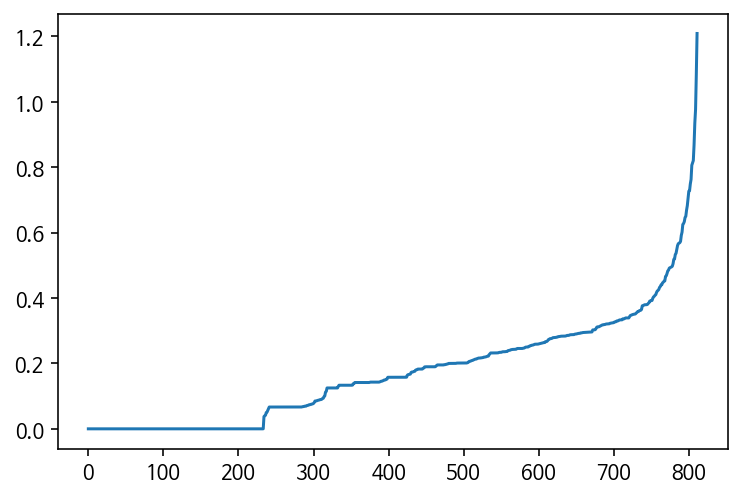

In [15]:
plt.plot(np.sort(distances[:,-1][47500:]))

eps: 0.4~0.5 로 하면 괜찮을 것 같음. (값이 기하급수적으로 튀는 부분을 eps로 설정하는 것)

-참고- 
- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

- https://stackoverflow.com/questions/43160240/how-to-plot-a-k-distance-graph-in-python



# DBSCAN application

In [16]:
# DBSCAN 적용할 데이터
X_train.head()

,old/building,bus,소로,crosswork
0,0.000000,5.375,0.066667,0.428571
1,0.447489,0.000,0.933333,0.285714
2,0.000000,-0.250,-0.333333,-0.285714
3,0.000000,-0.250,-0.333333,-0.142857
4,1.519380,0.250,1.200000,0.142857


In [17]:
scan_model = DBSCAN(eps=0.45)
clusters=scan_model.fit_predict(X_train)
print('클러스터 레이블:\n',clusters)

클러스터 레이블:
 [0 0 0 ... 0 0 0]


In [18]:
pd.Series(clusters).value_counts()

 0     47850
-1       145
 5        88
 3        42
 2        21
 8        19
 15       18
 1        16
 11       16
 12       14
 14       12
 17        9
 9         8
 16        8
 18        7
 7         7
 10        6
 6         6
 4         5
 20        5
 13        5
 19        5
dtype: int64

In [19]:
data['clusters'] = clusters
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building,binary_accident,clusters
0,195600.888993,545928.299315,6,0,0,1,0,0,0,0,0.0,1.0,5.0,93.0,45.0,0.0,0.0,0.0,0.000000,0.010753,0.0,0
1,194062.308207,544725.091085,19,0,0,1,0,0,0,0,1.0,3.0,4.0,219.0,2.0,0.0,2.0,1.0,0.004566,0.013699,1.0,0
2,197377.867009,543986.683138,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0
3,193058.182323,543489.087262,0,0,0,0,0,0,0,0,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.000000,0.071429,0.0,0
4,197347.383013,542701.828076,23,0,0,3,0,0,0,0,4.0,2.0,3.0,258.0,4.0,0.0,1.0,1.0,0.015504,0.007752,1.0,0


In [0]:
data.to_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/clusters_completed.csv')

---

# NEXT
- Cluster별로 변수의 가중치를 곱해 계산한 값을 변수로 다시 만들기. 어떤 클러스터가 중요한지 파악
- DBSCAN MAP Visualization
  - 0과 이상치 -1을 뺀 나머지의 clusters의 좌표를 활용해 시각화를 해보자.


